In [91]:
import warnings
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

from hmmlearn.hmm import GaussianHMM
from joblib import dump, load

from sklearn.preprocessing import *
from sklearn.metrics import *


In [2]:
mpl.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("Прошлые данные - CNY_RUB.csv", delimiter=',', decimal=',')
data = data.iloc[::-1].reset_index(drop=True)
data.set_index('Дата', inplace=True)
data.head(5)

,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
Дата,,,,,,
04.01.2010,4.4409,4.4088,4.4735,4.4088,NaN,"0,73%"
05.01.2010,4.4090,4.4409,4.4409,4.3805,NaN,"-0,72%"
06.01.2010,4.4081,4.4090,4.4090,4.3725,NaN,"-0,02%"
07.01.2010,4.4084,4.4081,4.4084,4.3679,NaN,"0,01%"
08.01.2010,4.3715,4.4084,4.4084,4.3715,NaN,"-0,84%"


In [4]:
n_sum = 40

In [5]:
cost = data['Цена']
cost_roll = cost.rolling(window=2, closed='both').mean().dropna()
cost_diff = cost_roll.diff().dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
X_scalled = scaler.fit_transform(np.array(cost_roll).reshape(-1, 1))

In [6]:
# dump(scaler, 'scaler.joblib')

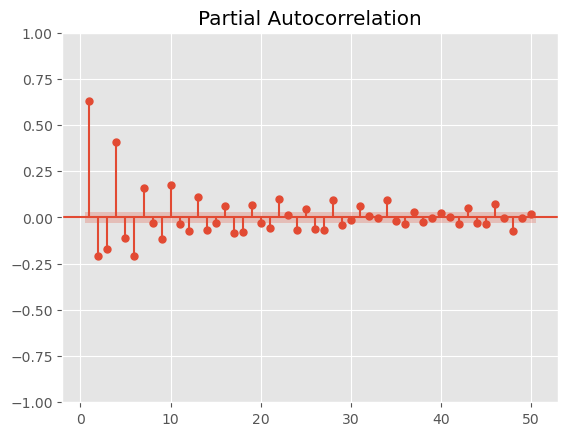

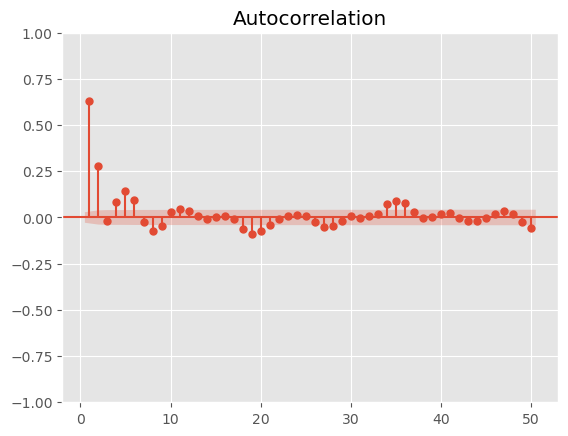

In [7]:
pacf = sm.graphics.tsa.plot_pacf(cost_diff, lags=50, zero=False)
acf = sm.graphics.tsa.plot_acf(cost_diff, lags=50, zero=False)

In [11]:
sarimax_result = load('SARIMAX.joblib')


In [103]:
model_sarimax = sm.tsa.SARIMAX(cost[:-n_sum], order=(7, 1, 2), seasonal_order=(4, 1, 0, 9))

sarimax_result = model_sarimax.fit()

print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Цена   No. Observations:                 4647
Model:             SARIMAX(7, 1, 2)x(4, 1, [], 9)   Log Likelihood                1922.716
Date:                            Sun, 18 May 2025   AIC                          -3817.432
Time:                                    17:40:52   BIC                          -3727.247
Sample:                                         0   HQIC                         -3785.703
                                           - 4647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373      0.063     13.218      0.000       0.713       0.961
ar.L2         -0.3956      0.056   

In [104]:
sarimax_predict_sum = sarimax_result.get_forecast(steps=n_sum).summary_frame(alpha=0.10)
sarimax_predict = sarimax_predict_sum['mean']
sarimax_predict_min = sarimax_predict_sum['mean_ci_lower']
sarimax_predict_max = sarimax_predict_sum['mean_ci_upper']

In [105]:

print("MSE", mean_squared_error(sarimax_predict, cost[-n_sum:])) 
print("MAE", mean_absolute_error(sarimax_predict, cost[-n_sum:])) 
print("MAPE", mean_absolute_percentage_error(sarimax_predict, cost[-n_sum:]))
print("r2", r2_score(sarimax_predict, cost[-n_sum:]))



MSE 0.8002260618767046
MAE 0.7646248307364371
MAPE 0.07251973490513755
r2 -0.5150341230528244


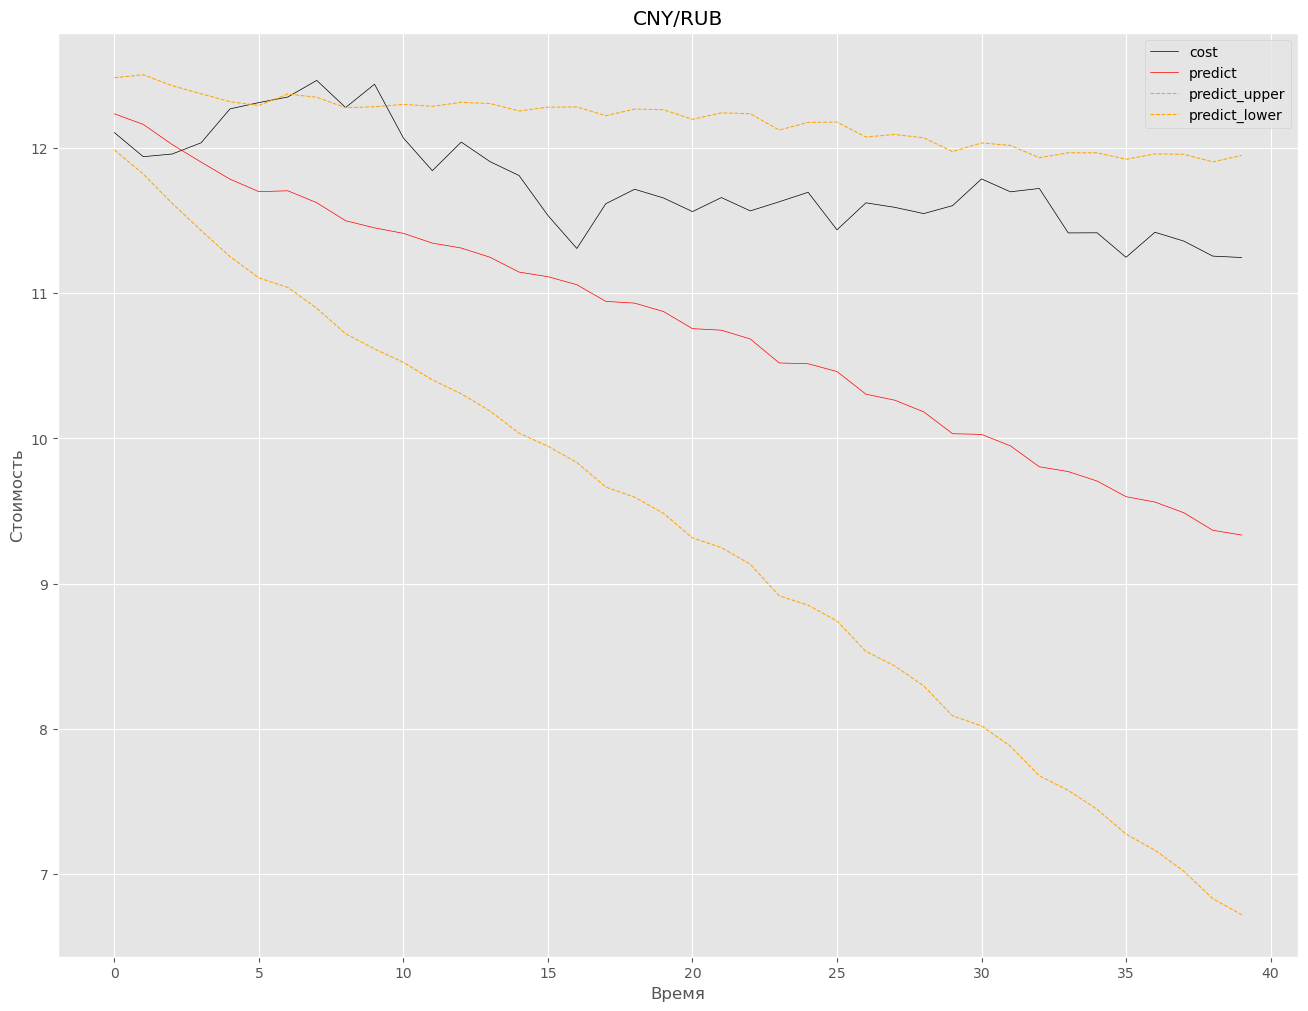

In [102]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(n_sum)], cost[-n_sum:], linewidth=0.5, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(n_sum)], sarimax_predict, linewidth=0.5, linestyle='-', color='red', label='predict', alpha=1)
axes.plot([i for i in range(n_sum)], sarimax_predict_max, linewidth=0.75, linestyle='--', color='orange', label='predict_upper', alpha=1)
axes.plot([i for i in range(n_sum)], sarimax_predict_min, linewidth=0.75, linestyle='--', color='orange', label='predict_lower', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()





In [107]:
model_sarimax = sm.tsa.SARIMAX(cost[:-n_sum], order=(8, 1, 9), seasonal_order=(4, 1, 0, 9))

sarimax_result = model_sarimax.fit()

In [108]:
sarimax_predict_sum = sarimax_result.get_forecast(steps=n_sum*2).summary_frame(alpha=0.10)
sarimax_predict = sarimax_predict_sum['mean']
sarimax_predict_min = sarimax_predict_sum['mean_ci_lower']
sarimax_predict_max = sarimax_predict_sum['mean_ci_upper']

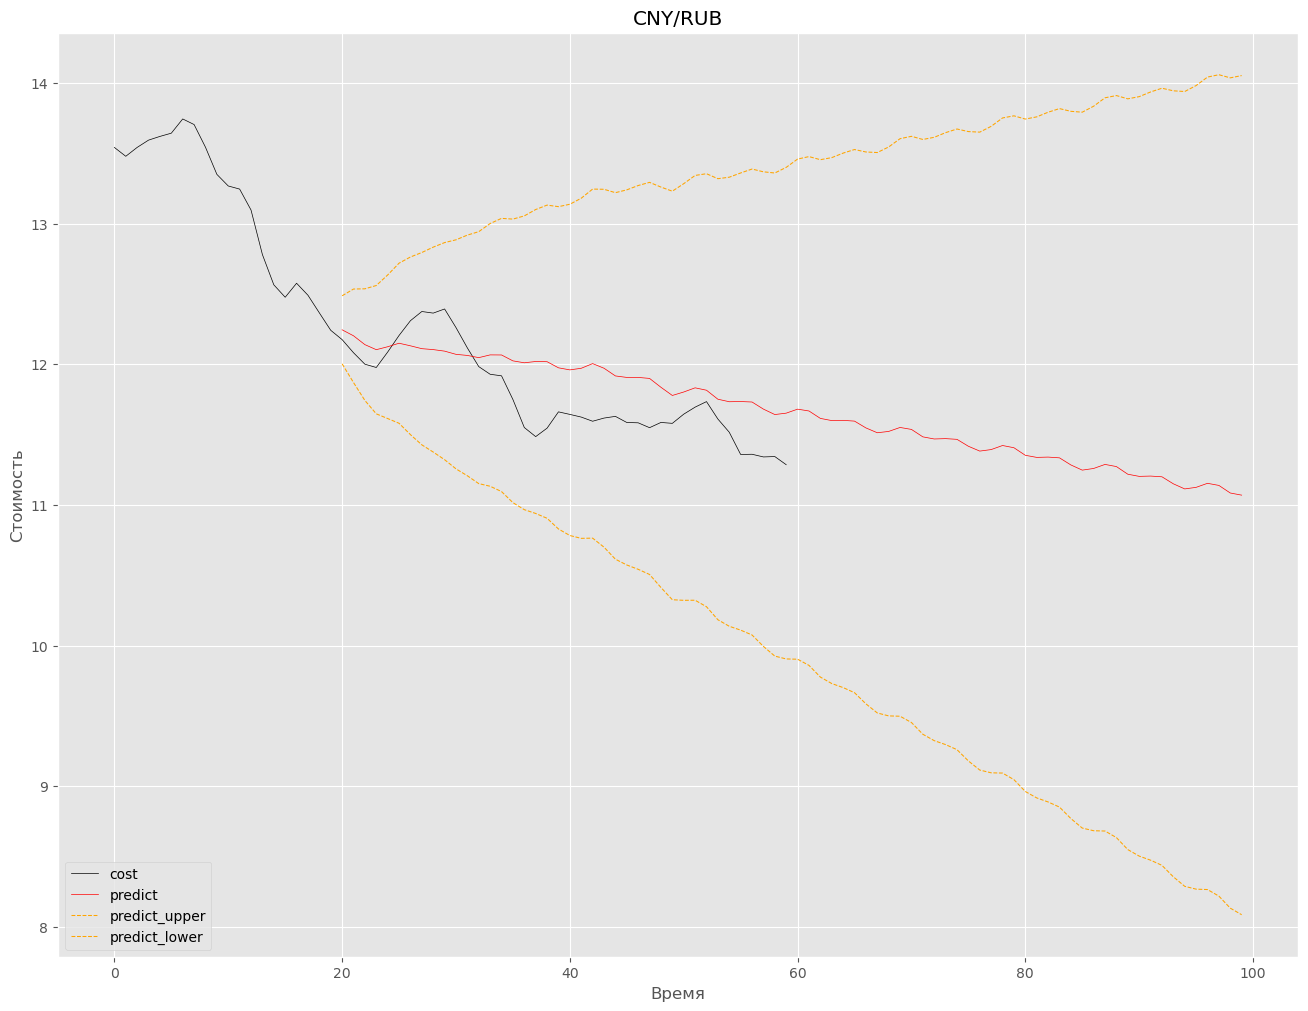

In [17]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(60)], cost_roll[-n_sum-20:], linewidth=0.5, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(20, 100)], sarimax_predict, linewidth=0.5, linestyle='-', color='red', label='predict', alpha=1)
axes.plot([i for i in range(20, 100)], sarimax_predict_max, linewidth=0.75, linestyle='--', color='orange', label='predict_upper', alpha=1)
axes.plot([i for i in range(20, 100)], sarimax_predict_min, linewidth=0.75, linestyle='--', color='orange', label='predict_lower', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()




In [86]:
# dump(sarimax_result, 'SARIMAX.joblib')

['SARIMAX.joblib']

In [18]:
model_hmm = load('HMM.joblib')

In [148]:
model_hmm = GaussianHMM(covariance_type = "tied", n_components = 11, n_iter = 1000, random_state = 0)

model_hmm.fit(np.array(np.array(cost_diff[:-n_sum]).reshape(-1, 1)))

GaussianHMM(covariance_type='tied', n_components=11, n_iter=1000,
            random_state=0)

In [19]:
samples, _= model_hmm.sample(n_sum)
# hmm_predict = scaler.inverse_transform(samples)
hmm_predict = samples

In [20]:
initial_price = cost.iloc[-n_sum - 1]  # Цена перед началом тестовой выборки

hmm_predict_p = np.cumsum(hmm_predict) + initial_price

In [21]:

print("MSE", mean_squared_error(hmm_predict, cost_diff[-n_sum:])) 
print("MAE", mean_absolute_error(hmm_predict, cost_diff[-n_sum:])) 
print("MAPE", mean_absolute_percentage_error(hmm_predict, cost_diff[-n_sum:]))
print("r2", r2_score(hmm_predict, cost_diff[-n_sum:]))



MSE 0.008880066334308242
MAE 0.06766223536775676
MAPE 4.630140683852476
r2 -0.5847135381370447


ValueError: x and y must have same first dimension, but have shapes (80,) and (40,)

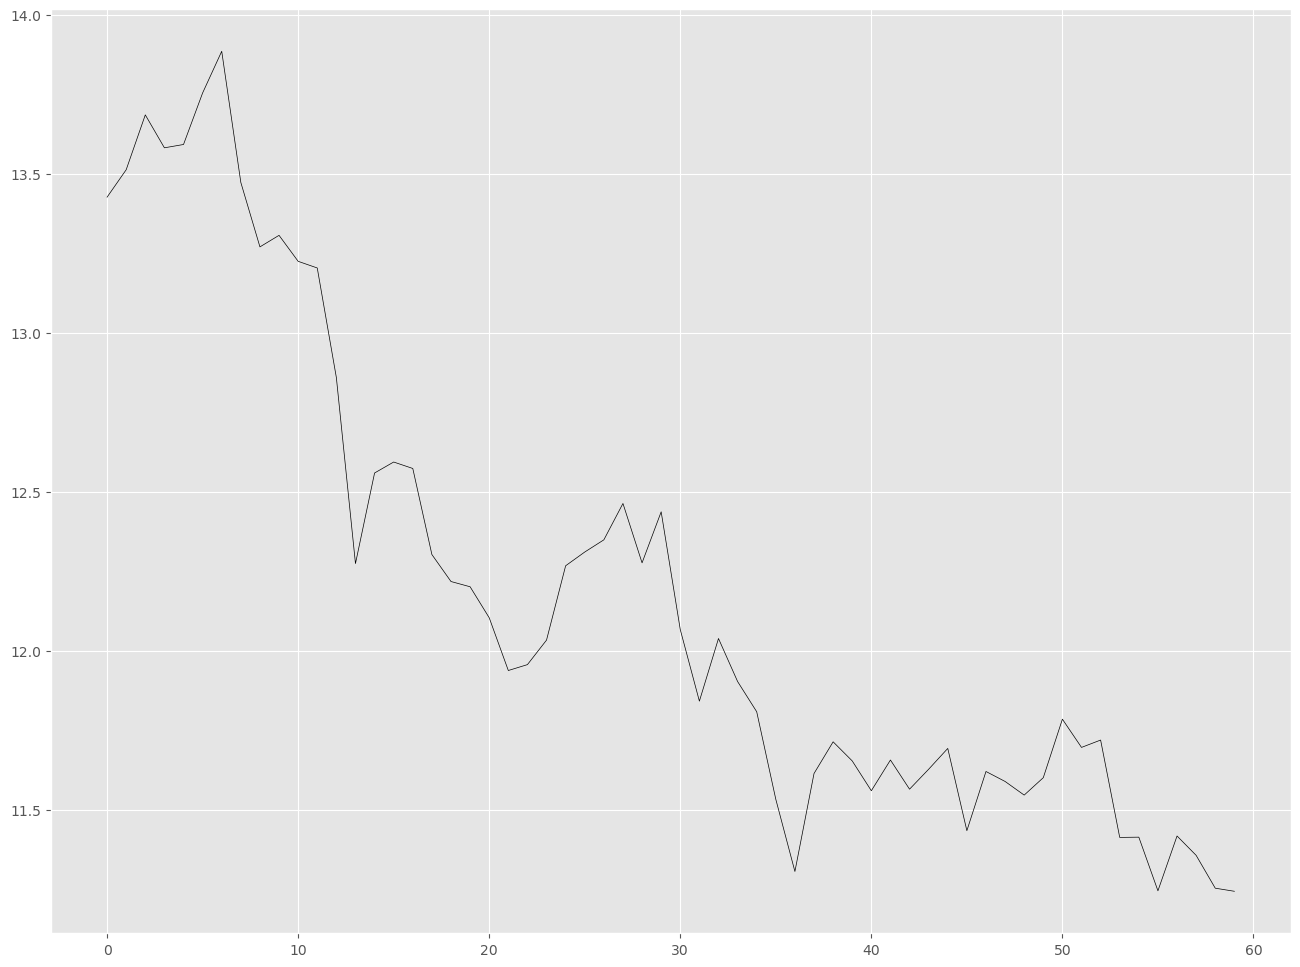

In [22]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(60)], cost[-n_sum-20:], linewidth=0.5, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(20, 100)], hmm_predict_p, linewidth=0.5, linestyle='-', color='red', label='predict', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()





In [ ]:
# dump(model_hmm, 'HMM.joblib')

In [157]:
model_hmm = GaussianHMM(covariance_type = "tied", n_components = 11, n_iter = 1000, random_state = 0)

model_hmm.fit(np.array(np.array(cost_diff[:-n_sum]).reshape(-1, 1)))

GaussianHMM(covariance_type='tied', n_components=11, n_iter=1000,
            random_state=0)

In [23]:
samples, _= model_hmm.sample(n_sum*2)
# hmm_predict = scaler.inverse_transform(samples)
hmm_predict = samples

In [24]:
initial_price = cost.iloc[-n_sum - 1]  # Цена перед началом тестовой выборки

hmm_predict_p = np.cumsum(hmm_predict) + initial_price

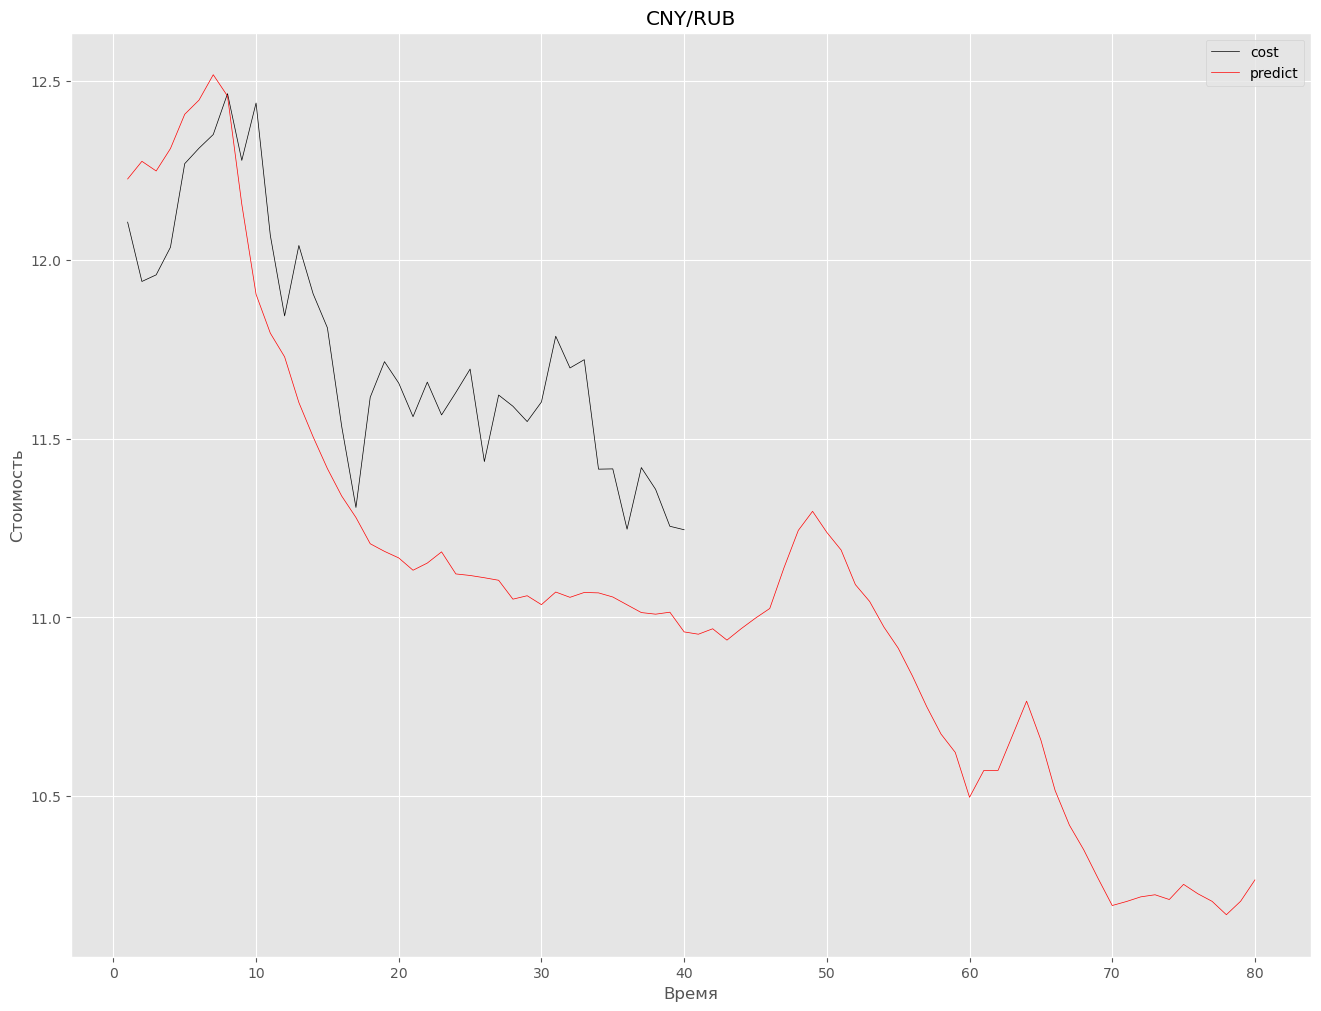

In [25]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(1, n_sum + 1)], cost[-n_sum:], linewidth=0.5, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(1, n_sum*2+1)], hmm_predict_p, linewidth=0.5, linestyle='-', color='red', label='predict', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()





In [123]:
# model_lstm = keras.models.load_model("LSTM_220425_day_1_CNY.h5")
# model_lstm = keras.models.load_model("LSTM_240425_day_2_cny.h5")
model_lstm = keras.models.load_model("test_model_lstm.keras")


OSError: Unable to open file (file signature not found)

In [27]:
def make_predictions_lstm(model, input_data, n_future_steps):
    """
    Прогнозирование будущих значений.
    
    :model: обученная модель (например, LSTM)
    :input_data: последние данные для инициализации (массив размера (sequence_length, 1))
    :n_future_steps: количество будущих шагов для прогнозирования
    :return: массив с прогнозируемыми значениями
    """
    future_predictions = []  # Для сохранения прогнозов
    
    # Инициализируем текущий вход
    current_input = input_data.copy()  # Копируем входные данные
    current_input = np.reshape(current_input, (sequence_length, 1))  # Убедимся в правильной размерности
    
    for _ in range(n_future_steps):
        # Добавляем измерение батча (batch_size=1) для совместимости с моделью
        current_input_reshaped = np.expand_dims(current_input, axis=0)  # Размерность: (1, sequence_length, 1)
        
        # Проверяем размерность перед прогнозированием
        # print("Размерность current_input_reshaped:", current_input_reshaped.shape)
        
        # Прогнозируем следующее значение
        predicted_value = model.predict(current_input_reshaped, verbose=0)
        
        # Сохраняем прогноз
        future_predictions.append(predicted_value[0, 0])
        
        # Обновляем текущий вход (добавляем прогноз и удаляем самое старое значение)
        current_input = np.append(current_input[1:], predicted_value)
        current_input = np.reshape(current_input, (sequence_length, 1))  # Убедимся в правильной размерности
    
    return np.array(future_predictions)

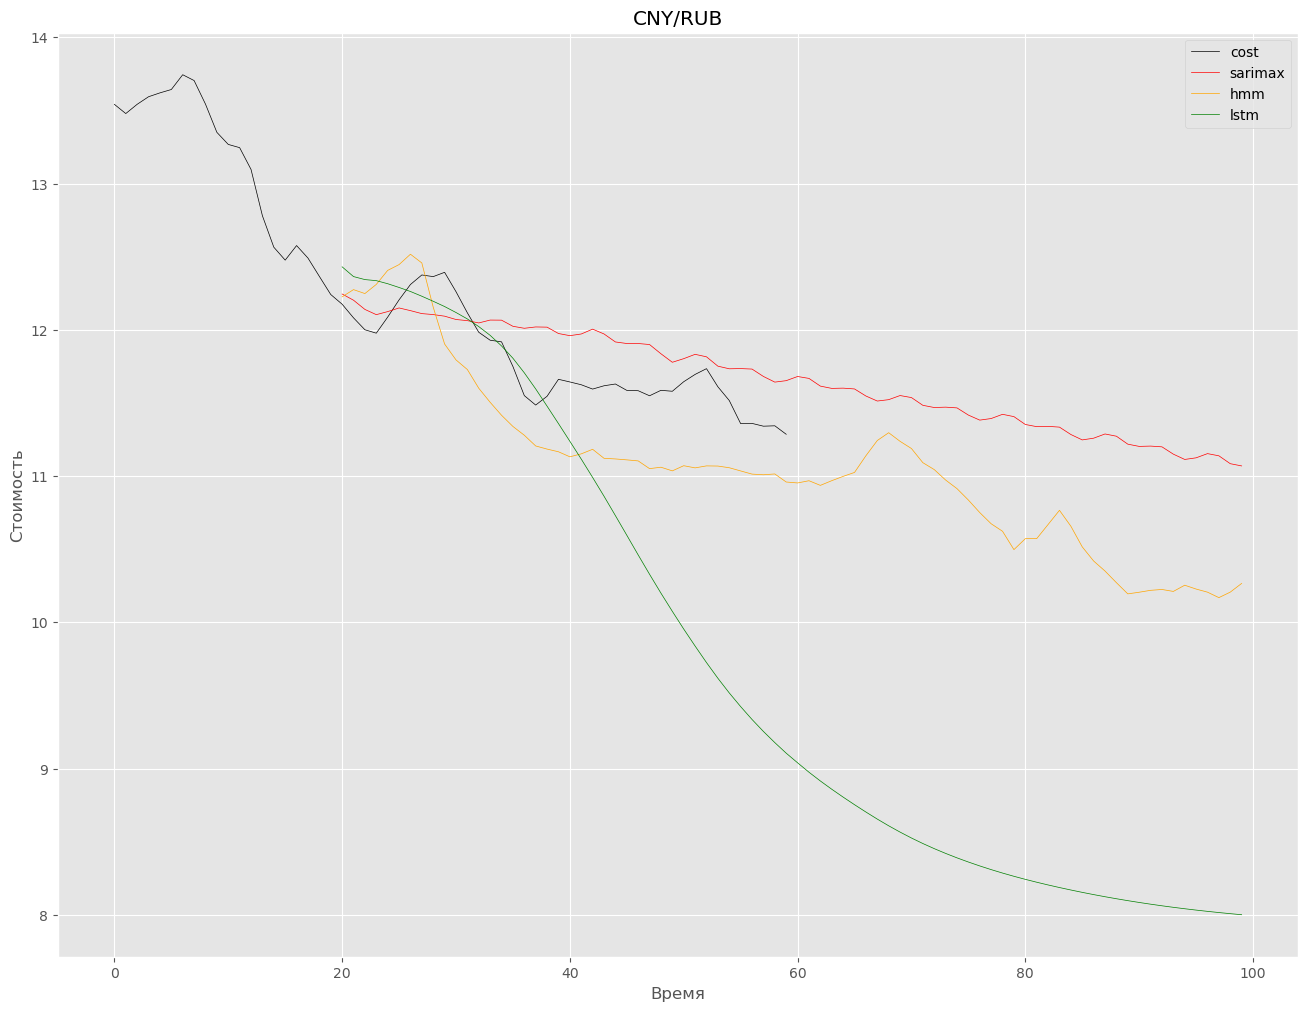

In [111]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(60)], cost_roll[-n_sum-20:], linewidth=0.5, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(20, 100)], sarimax_predict, linewidth=0.5, linestyle='-', color='red', label='sarimax', alpha=1)
axes.plot([i for i in range(20, 100)], hmm_predict_p, linewidth=0.5, linestyle='-', color='orange', label='hmm', alpha=1)
axes.plot([i for i in range(20, 100)], lstm_predict, linewidth=0.5, linestyle='-', color='green', label='lstm', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()




In [28]:
from sklearn.model_selection import *

sequence_length = n_sum # Длина последовательности для входных данных
X_lstm, y_lstm = [], []

for i in range(sequence_length, len(X_scalled)):
        X_lstm.append(X_scalled[i-sequence_length:i, 0])
        y_lstm.append(X_scalled[i, 0])


X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


X_train_lstm = X_lstm[:-n_sum]
y_train_lstm = y_lstm[:-n_sum]

X_test_lstm = X_lstm[-n_sum:]
y_test_lstm = y_lstm[-n_sum:]


In [29]:
lstm_predict = make_predictions_lstm(model_lstm, X_test_lstm[0], 80)
lstm_predict = scaler.inverse_transform(lstm_predict.reshape(-1, 1))

In [89]:
# ansamble_predict = (np.array(sarimax_predict).reshape(-1, 1) + hmm_predict_p.reshape(-1, 1) + lstm_predict ) / 3
ansamble_predict = (np.array(sarimax_predict).reshape(-1, 1) * 0.6 + hmm_predict_p.reshape(-1, 1) * 0.3 + lstm_predict * 0.1)


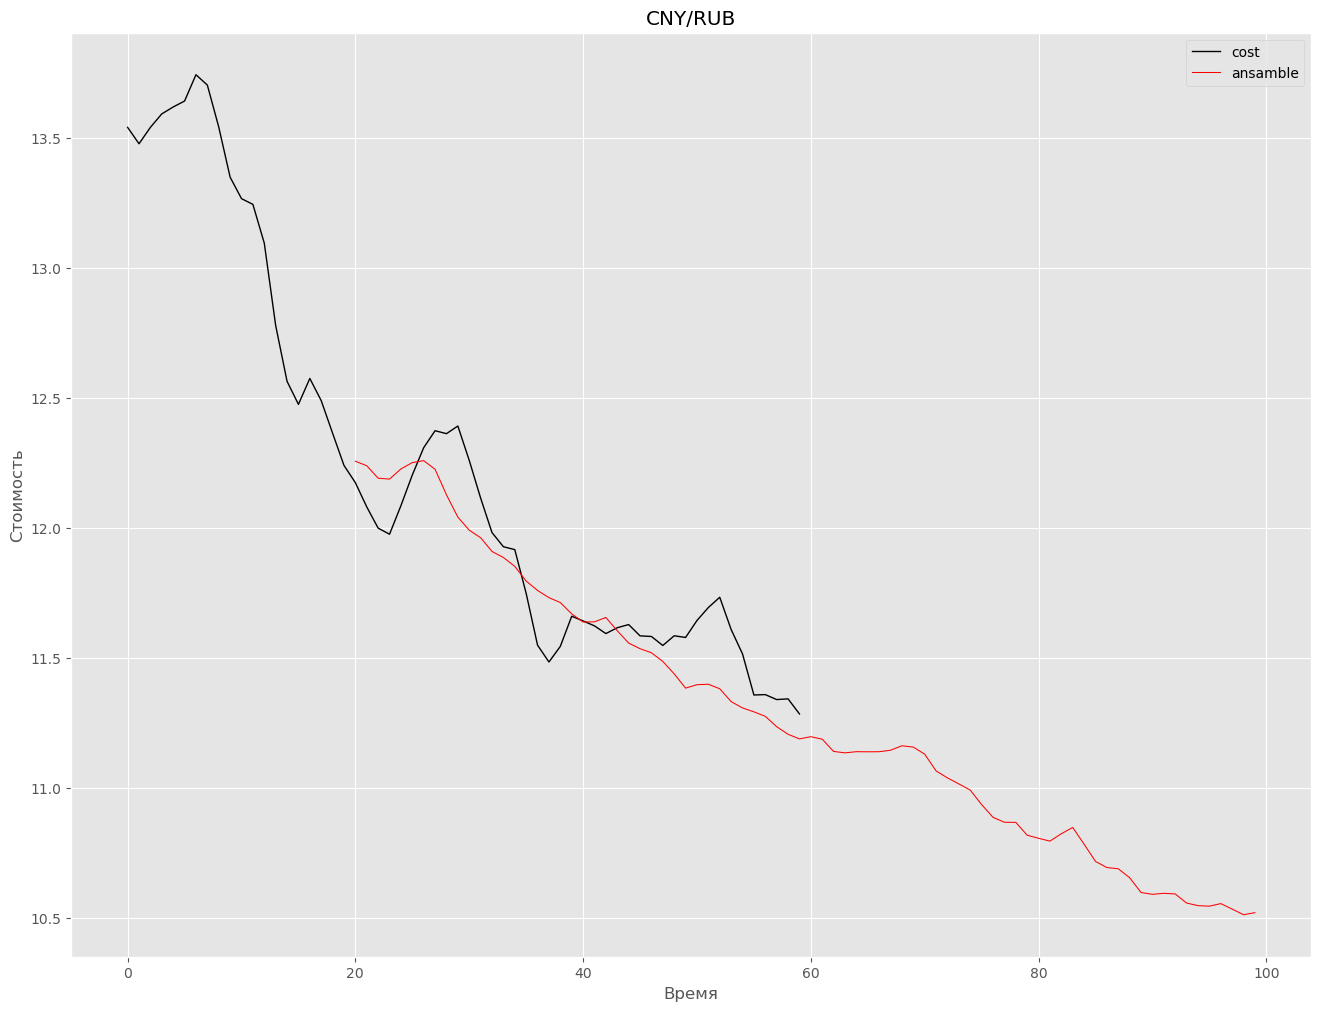

In [109]:
fig, axes = plt.subplots(figsize=(16, 12))


axes.plot([i for i in range(60)], cost_roll[-n_sum-20:], linewidth=1, linestyle='-', color='black', label='cost', alpha=1)
axes.plot([i for i in range(20, 100)], ansamble_predict, linewidth=0.75, linestyle='-', color='red', label='ansamble', alpha=1)


axes.set_title('CNY/RUB')

axes.set_xlabel('Время')


axes.set_ylabel('Стоимость')


plt.legend()
plt.show()




In [88]:
ansamble_predict_t = (
    (
        np.array(sarimax_predict).reshape(-1, 1) * 0.6 + 
                       hmm_predict_p.reshape(-1, 1) * 0.3 +
                       lstm_predict * 0.1
    )
)[:40]

print("MSE", mean_squared_error(ansamble_predict_t, cost[-n_sum:])) 
print("MAE", mean_absolute_error(ansamble_predict_t, cost[-n_sum:])) 
print("MAPE", mean_absolute_percentage_error(ansamble_predict_t, cost[-n_sum:]))
print("r2", r2_score(ansamble_predict_t, cost[-n_sum:]))



MSE 0.03261346375737001
MAE 0.14115588096381057
MAPE 0.012028060520448627
r2 0.725720493824331
